# Figure 2

## Fourier Ring Correlation to estimate image improvement with increasing density of localizations.

----

Import all necessary modules, and the TensorFlow FRC functions from the file `frc_loss.py`:

In [1]:
import pandas as pd
import numpy as np
import os, fnmatch
from skimage import exposure
from skimage.filters import gaussian
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from frc_loss import FRC_loss, smlm_frc, get_kernel_list

Initialize GPU and limit memory usage:

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

Load localization file for panel a:

In [3]:
data = pd.read_csv("data/spot2.csv",delimiter=',')
data = data.query('5000<`y [nm]`<7500 and 6000<`x [nm]`<8500 and `uncertainty_xy [nm]`<50')

Get a random sample of 10% of all localizations to simulate reduced localization density:

In [4]:
subdata = data.sample(frac=0.1)

Generate histogram images of the localization data:

In [5]:
pixel_size = 10;

x = data["x [nm]"].to_numpy()
y = data["y [nm]"].to_numpy()

xs = subdata["x [nm]"].to_numpy()
ys = subdata["y [nm]"].to_numpy()

xbins = np.arange(x.min(), x.max()+1, pixel_size)
ybins = np.arange(y.min(), y.max()+1, pixel_size)

img1,xe,ye = np.histogram2d(y,x,bins=(ybins,xbins));
img2,xe,ye = np.histogram2d(ys,xs,bins=(ybins,xbins));

img2[img2>1] = 1

Render the full density image with scale bar:

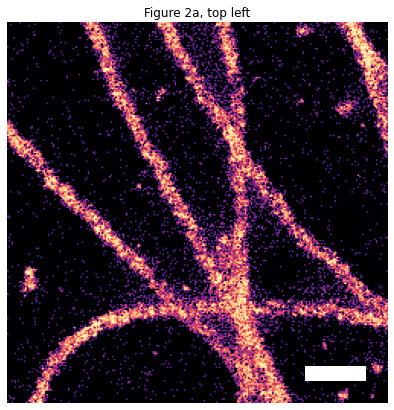

In [6]:
plt.figure(figsize=(7,7))
plt.imshow(exposure.equalize_hist(img1),cmap=plt.get_cmap("magma"))
plt.plot((200,230), (230,230), color='white', linewidth=15)
plt.axis("off")
plt.title("Figure 2a, top left")
plt.show()

Render the same image with 10% of localizations:

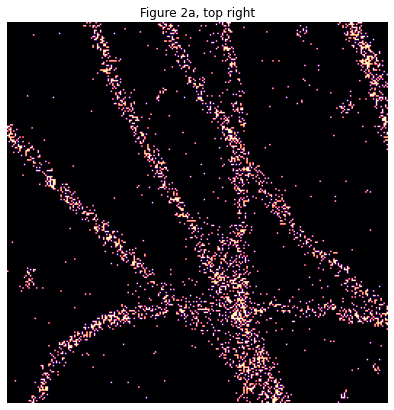

In [7]:
plt.figure(figsize=(7,7))
plt.imshow(exposure.equalize_hist(img2),cmap=plt.get_cmap("magma"))
plt.axis("off")
plt.title("Figure 2a, top right")
plt.show()

----

Load precomputed data files for panels b-c:

In [8]:
all_loss02 = np.load("data/loss02.npy")
all_loss05 = np.load("data/loss05.npy")
all_f = np.load("data/fc.npy")

Calculate and plot the FRC curve for the full density image:

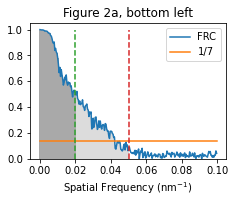

In [9]:
frc, fc, loss02, loss05 = smlm_frc(data, frac=1.0, pixel_size=5)

f_range = 1/pixel_size*np.arange(img1.shape[0])/img1.shape[0]

plt.figure(figsize=(3.5,2.5))
plt.plot(f_range,frc,label = 'FRC')
plt.plot(f_range, np.ones((250))*1/7, label='1/7');
plt.plot((0.02, 0.02),(0.0, 1.0),'--');
plt.plot((0.05, 0.05),(0.0, 1.0),'--');
plt.bar(f_range[:125],frc[:125], width=0.001, color="gainsboro")
plt.bar(f_range[:50],frc[:50], width=0.001, color="darkgray")
plt.legend()
plt.xlabel('Spatial Frequency (nm$^{-1}$)')
plt.title("Figure 2a, bottom left")
plt.show()

Calculate and plot the FRC curve for the 10% density image:

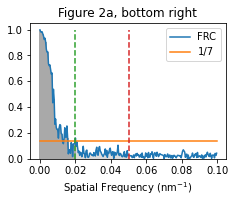

In [10]:
frc, fc, loss02, loss05 = smlm_frc(data, frac=0.1, pixel_size=5)

x1 = np.arange(250)/500

kernel = np.ones((5))/5
frc_smooth = frc.numpy()
frc_smooth[2:] = np.convolve(frc[2:],kernel, mode="same")

plt.figure(figsize=(3.5,2.5))
plt.plot(f_range,frc,label = 'FRC')
plt.plot(f_range, np.ones((250))*1/7, label='1/7')
plt.plot((0.02, 0.02),(0.0, 1.0),'--');
plt.plot((0.05, 0.05),(0.0, 1.0),'--');
plt.bar(f_range[:125],frc[:125], width=0.001, color="gainsboro")
plt.bar(f_range[:50],frc[:50], width=0.001, color="darkgray")
plt.legend()
plt.xlabel('Spatial Frequency (nm$^{-1}$)')
plt.title("Figure 2a, bottom right")
plt.show()

Plot the cutoff-dependent FRC resolution and q for all fractions of localizations:

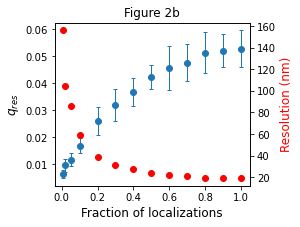

In [11]:
frac = (0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0)

fig, ax = plt.subplots(1,1, figsize=(3.5,3))

yval = f_range[np.round(all_f.mean(axis=0)).astype(int)]
y_err = f_range[np.round(all_f.std(axis=0)).astype(int)]

plt.errorbar(frac, yval, yerr=f_range[np.round(all_f.std(axis=0)).astype(int)], marker='o', linewidth=0, elinewidth=1, capsize=2, markeredgewidth=1)
plt.xlabel('Fraction of localizations', fontsize=12)
plt.ylabel('$q_{res}$', fontsize=12)
ax2 = ax.twinx()
ax2.errorbar(frac, 1/yval, yerr=y_err, marker='o', linewidth=0, elinewidth=1, capsize=2, markeredgewidth=1, color="red")
ax2.set_ylabel('Resolution (nm)', color="red", fontsize=12)
plt.title("Figure 2b")
plt.show()

Plot the FRC area loss for a fraction of 0.2 and 0.5 of the frequency range:

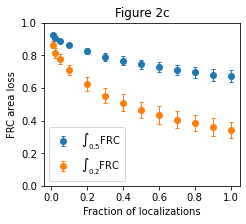

In [12]:
plt.figure(figsize=(3.5,3.0))
plt.errorbar(frac, all_loss05.mean(axis=0), yerr=all_loss05.std(axis=0), marker='o', linewidth=0, elinewidth=1, capsize=2, markeredgewidth=1, label="$\int_{0.5}$FRC")
plt.errorbar(frac, all_loss02.mean(axis=0), yerr=all_loss02.std(axis=0), marker='o', linewidth=0, elinewidth=1, capsize=2, markeredgewidth=1, label="$\int_{0.2}$FRC")
plt.xlabel('Fraction of localizations')
plt.ylabel('FRC area loss')
plt.ylim(0,1)
plt.legend(loc="lower left")
plt.title("Figure 2c")
plt.show()